# Solar System Equations of Motion
 Russell Burns, Neeltje Kackar, Ab Lesesne, Corey Martin, Patrick Sheridan

# Preamble

In [127]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import math
import scipy.integrate as it
from scipy.integrate import solve_ivp
import scipy.interpolate as ip
from mpl_toolkits.mplot3d import Axes3D

In [128]:
def vsolve_rk4(f,t,q0):
  q0=np.asarray(q0)
  t=np.asarray(t)
  q=np.zeros( (len(t),len(q0)) )
  q[0]=q0
  for i in range(0,len(t)-1):
    h=t[i+1]-t[i]
    k1=h*f(q[i],t[i])
    k2=h*f(q[i]+k1/2, t[i]+h/2)
    k3=h*f(q[i]+k2/2, t[i]+h/2)
    k4=h*f(q[i]+k3, t[i]+h)
    q[i+1]=q[i]+(1/6)*(k1+2*k2+2*k3+k4)
  return q

# Abstract


We solved the 3D equations of motion for the solar system via 2nd order ODES. Our differential function `qprimegrav`, along with a array of initial positions and velocities of selected planets, act as an input for `vsolve_rk4`. The solution maps the respective orbits over a specified time, primarily as 2D projections (with one exception). We use those results to perform predictive analysis of different parts of the system.

# Assumptions and Equations

We first define the solar system:

* The Sun
* 8 inner planets
* Earth's moon

To simplify the EOM, we've neglected the force contributions of the astroid belt as its mass is insignificant (only 3% of Earth's moon). We ignored all other moons in the solar system, which includes the four that are more massive than Earth's moon.

Consider Newton's 2nd Law, expanded to include celestial bodies:

$$\mathbf{F}_i = m_i \mathbf{a}_i = m_i \mathbf{v}_i' = m_i \mathbf{r}_i''  = \sum_{j\neq i} \mathbf{F}_{ji} = \sum_{j\neq i} \frac{G m_i m_j}{|\mathbf{r}_j - \mathbf{r}_i|^3}(\mathbf{r}_j-\mathbf{r}_i)$$



Where $\mathbf{F}_i$ is the force acting upon the $i$th body of mass $m_i$, velocity $\mathbf{v}_i = (v_{x_i}, v_{y_i},v_{z_i})$, and position $\mathbf{r}_i = (x_i,y_i,z_i)$. This information is relative to every other system body $j$ of mass $m_j$, velocity $\mathbf{v}_j = (v_{x_j}, v_{y_j},v_{z_j})$, and position $\mathbf{r}_j = (x_j,y_j,z_j)$. $G$ is the graviational constant, equal to $6.6743\times 10^{-11}  \mathrm{m}^3 \mathrm{kg}^{-1} \mathrm{s}^{-2}$.

We will work in distance units of AU, velocity units of AU/day, and SI units of time.

#Initial Conditions

We are using a fourth-order Runge-Kutta method to solve these EOM. The method takes in a one-dimensional initial conditions array $q_{initial}$ with columns of the kinematic variables of interest. The method also takes in array of desired times $t$ and a differential equation f(q,t). The change determined by f**'**($q_{first}$, $t_{first}$) then helps determine $q_{second}$ at $t_{second}$. These $q$s will fill in rows underneath $q_{initial}$ for each entry in $t$. `vsolve_rk4` only works with 1-dimensional arrays, so we flatten _q_ before the method is called and reshape it after.

Since we aim to plot the trajectories, we included position and velocity as the variables of interest for $q$.

| $q_0$   | $q_1$    |   $q_2$ | $q_3$   |$q_4$    | $q_5$   |
| -------- | ------- |-------- | ------- |-------- | ------- |
| $x$   | $y$    |   $z$ | $v_x$   |$v_y$    | $v_z$   |

Knowing this structure, we had to compile the data necessary to create a per-planet $q_{initial}$ of an easily accessible format.

[NASA/JPL's HORIZONS web app provided all the data we needed](https://ssd.jpl.nasa.gov/horizons/app.html#/) for $q_{initial}$. We accessed the masses, positions, and velocities of the 10 solar bodies at 2459886.500000000, A.D. 2022-Nov-03 00:00:00.0000 (Julian, UT). The data was measured from the ICRF reference frame (interial COM of the solar system).

The resultant list can be found [here](https://gist.githubusercontent.com/Theelx/acf32843d9b878ab12fbdfdf6354560e/raw/da92ab5addaac75541066a8c16bf67286061ef98/astro_data.csv).


# Satellite Orbit

To begin, the team coded a a two-body differential function `qprimesat(q, t, m, G)` to test the waters before writing `qprimegrav`. This function only considers a situation between an orbiting satellite and the pirmary body (earth here). This approach required some assumptions:

* $q_{earth}$ = (0, 0, 0, 0, 0, 0)
* $q_{moon}$ = (42164000, 0, 0, 0, 3073.566, 0)

Where $q_0$ of the satellite is the distance from the center of the earth it must be at to enter geosynchrous orbit altitude, and $q_5$ of the satellite is the tangential velocity it will hold at geosynchrous orbit (according to $v = \omega_{earth} * r$, where $r = q_0$ and $\omega_{earth} = \frac{2\pi}{(24*60*60)} $ ). A timespace of just under 24 hours was provided across 100 time slices.



In [129]:
mearth=[5.97219e24,100]

def qprimesat(q, t,m = mearth, G=6.6743e-11):
  qprime=np.zeros_like(q)
  qprime2=np.zeros_like(qsatellite)
  qhistory=[]
  for i in range(len(qsatellite)):
    qprime[6*i]=q[6*i+3]
    qprime[6*i+1]=q[6*i+4]
    qprime[6*i+2]=q[6*i+5]
    distance=np.zeros((len(qsatellite),3))
    totaldistance = np.zeros(len(qsatellite))
    for j in range(len(qsatellite)):
      for xyz in [0, 1, 2]:
                    distance[j][xyz] = q[6*i+xyz] - q[6*j+xyz]
                    totaldistance[j] = np.sqrt(distance[j][0] ** 2 + distance[j][1] ** 2 + distance[j][2]**2)
                    temp_A = np.zeros(3)
                    if totaldistance[j] != 0:
                        for xyz in [0, 1, 2]:
                            temp_A[xyz] = (G*m[j])/((totaldistance[j])**3)*(-distance[j][xyz])
      qprime[6*i+3] += temp_A[0]
      qprime[6*i+4] += temp_A[1]
      qprime[6*i+5] += temp_A[2]
  return qprime

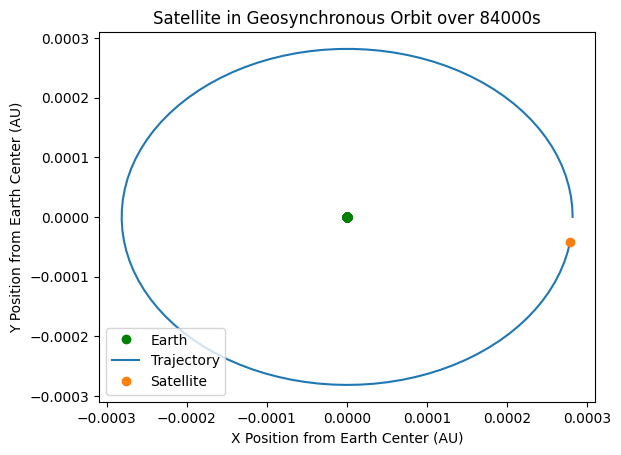

In [130]:
t0,tf=0,84000
t=np.linspace(t0,tf,100)
qsatellite=[[0,0,0,0,0,0],[42164000,0,0,0,3073.566,0]]
qsatellite0=np.reshape(qsatellite, (len(qsatellite[0])*len(qsatellite)))
qprimesat_sol=vsolve_rk4(qprimesat,t,qsatellite0)
positions = np.reshape(qprimesat_sol, (len(qprimesat_sol), len(qprimesat_sol[0])//6, 6))[:,:,(0,1,2)]
positions=positions*6.6846e-12
namessat=["Earth","Satellite", "Trajectory"]
selectedplanets=[0,1]
axes=[0,1]
for s in selectedplanets:
  if s != 0:
    plt.plot(positions.T[axes[0]][s],positions.T[axes[1]][s],label=namessat[2])
    plt.plot(positions.T[axes[0]][s][len(t)-1],positions.T[axes[1]][s][len(t)-1],'o', label=namessat[s])
    plt.legend()
  if s==0:
    plt.plot(positions.T[0][0],positions.T[1][0],'go',label=namessat[s])
    plt.legend()
plt.xlabel("X Position from Earth Center (AU)")
plt.ylabel("Y Position from Earth Center (AU)")
plt.title("Satellite in Geosynchronous Orbit over 84000s");

# General Orbit Function

The general function, `qprimegrav(q, t, m, G)`, did not require much more modification. It simply needed to iterate through each possible pair of bodies to obtain the resultant forces. Once the function was written, we respectively plotted the inner and outer planets for a period of one earth year. Diamonds represent the final position of each planet.

In [131]:
q = pd.read_csv(
    "https://gist.githubusercontent.com/Theelx/acf32843d9b878ab12fbdfdf6354560e/raw/da92ab5addaac75541066a8c16bf67286061ef98/astro_data.csv"
).to_numpy()
names = ["Sun", "Mercury", "Venus", "Earth", "Luna", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"]
#1 m/s = 5.77548e-7 au/day
#1 m = 6.6846e-12 au       m/au  = 6.6846e-12

#1 s = 1.1574e-5 days      s/day = 1.1574e-5
#1/s = 8.64e4 1/days
#G = 6.6738e-11 m^3/(kg*s^2)  =>  multiply by (au/m)^3, (s/day)^2  => G=
q = np.delete(q, 0, 1)
q=np.delete(q,6,1)*1000
q[3][0]=-q[3][0]
q[3][3]=-q[3][3]
q0=np.reshape(q, (len(q[0])*len(q)))
q2=q
planet_masses = np.array(
    [
        1.989e30,
        3.301e23,
        4.867e24,
        5.972e24,
        7.348e22,
        6.417e23,
        1.898e27,
        5.683e26,
        8.681e25,
        1.024e26,
    ]
)
def qprimegrav(q, t, m=planet_masses, G=6.6743e-11):

    qprime = np.zeros_like(q)
    qprime2 = np.zeros_like(q2)
    qhistory = []
    nones = np.array([0, 0, 0])
    for i in range(len(q2)):
        qprime[6 * i] = q[6 * i + 3]
        qprime[6 * i + 1] = q[6 * i + 4]
        qprime[6 * i + 2] = q[6 * i + 5]
        distance = np.zeros((len(q2), 3))
        totaldistance = np.zeros(len(q2))
        for j in range(len(q2)):
            for xyz in [0, 1, 2]:
                distance[j][xyz] = q[6 * i + xyz] - q[6 * j + xyz]
        totaldistance = np.sqrt((distance * distance).sum(axis=1))
        indicies = np.where(totaldistance != 0)
        temp_As1 = G * m[indicies] / ((totaldistance[indicies]) ** 3)
        temp_As = (temp_As1 * (-distance[indicies]).T).T
        inc = 0
        for j in range(len(q2)):
            if totaldistance[j] != 0:
                temp_A = temp_As[j-inc]
            else:
                inc += 1
                temp_A = np.zeros(3)
            # incrementing each individually is about 25% faster than incrementing them all at once
            qprime[6 * i + 3] += temp_A[0]
            qprime[6 * i + 4] += temp_A[1]
            qprime[6 * i + 5] += temp_A[2]
    return qprime
qprime = qprimegrav(q0,100,m=planet_masses, G=6.6743e-11)

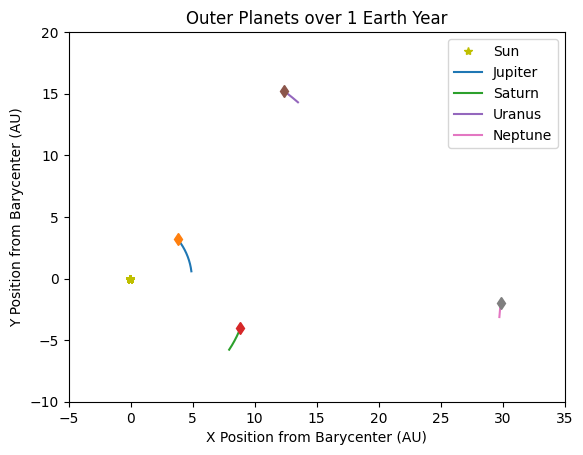

In [132]:
t0,tf=0,31536000
t=np.linspace(t0,tf,30000)
qprimegrav_sol=vsolve_rk4(qprimegrav,t,q0)
positions = np.reshape(qprimegrav_sol, (len(qprimegrav_sol), len(qprimegrav_sol[0])//6, 6))[:,:,(0,1,2)]
selectedplanets=[0,6,7,8,9]
positions=positions*6.6846e-12
axes=[0,1]
for s in selectedplanets:
  if s != 0:
    plt.plot(positions.T[axes[0]][s],positions.T[axes[1]][s],label=names[s])
    plt.plot(positions.T[axes[0]][s][len(t)-1],positions.T[axes[1]][s][len(t)-1],'d')
    plt.legend()
  if s==0:
    plt.plot(positions.T[0][0],positions.T[1][0],'y*', label = names[s])
plt.xlabel("X Position from Barycenter (AU)")
plt.ylabel("Y Position from Barycenter (AU)")
plt.title("Outer Planets over 1 Earth Year")
plt.ylim(-10,20)
plt.xlim(-5,35);

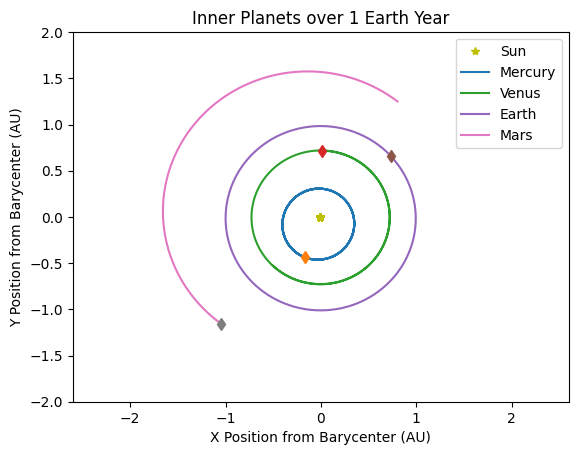

In [133]:
t0,tf=0,31536000
t=np.linspace(t0,tf,10000)
qprimegrav_sol=vsolve_rk4(qprimegrav,t,q0)
positions = np.reshape(qprimegrav_sol, (len(qprimegrav_sol), len(qprimegrav_sol[0])//6, 6))[:,:,(0,1,2)]
selectedplanets=[0,1,2,3,5]
positions=positions*6.6846e-12
axes=[0,1]
for s in selectedplanets:
  if s != 0:
    plt.plot(positions.T[axes[0]][s],positions.T[axes[1]][s],label=names[s])
    plt.plot(positions.T[axes[0]][s][len(t)-1],positions.T[axes[1]][s][len(t)-1],'d')
    plt.legend()
  if s==0:
    plt.plot(positions.T[0][0],positions.T[1][0],'y*', label = names[s])
plt.ylim(-2,2)
plt.xlim(-2.6,2.6)
plt.legend()
plt.xlabel("X Position from Barycenter (AU)")
plt.ylabel("Y Position from Barycenter (AU)")
plt.title("Inner Planets over 1 Earth Year");

# Mercury Orbit Example

For an up close look, we solved the solar system for a period of 87 days and concentrated on Mercury's orbit. Mercury's period is 88 days, so we wanted to verify that it almost returns to its starting point. We then plotted the orbit's distance vs. time from the barycenter to find the perihelion and aphelion, which were very close to reality. We also the predicted amount of time until those events occurred.

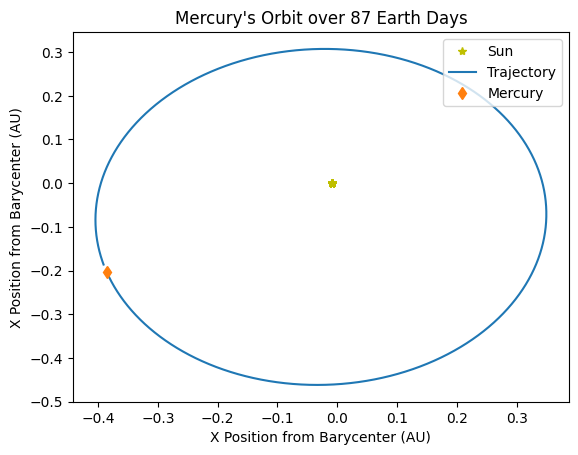

In [134]:
t0,tf=0,7516800
t=np.linspace(t0,tf,5000)

qprimegrav_sol=vsolve_rk4(qprimegrav,t,q0)
positions = np.reshape(qprimegrav_sol, (len(qprimegrav_sol), len(qprimegrav_sol[0])//6, 6))[:,:,(0,1,2)]
positions=positions*6.6846e-12
selectedplanets=[0,1]
axes=[0,1]
for s in selectedplanets:
  if s != 0:
    plt.plot(positions.T[axes[0]][s],positions.T[axes[1]][s],label="Trajectory")
    plt.plot(positions.T[axes[0]][s][0],positions.T[axes[1]][s][0],'d', label=names[s])
  if s==0:
    plt.plot(positions.T[0][0],positions.T[1][0],'y*', label=names[s])
plt.legend(loc='upper right')
plt.xlabel("X Position from Barycenter (AU)")
plt.ylabel("X Position from Barycenter (AU)")
plt.title("Mercury's Orbit over 87 Earth Days");

Mercury will reach its 0.304 AU perihelion 59.328 days from now
Mercury will reach its 0.468 AU aphelion 14.758 days from now


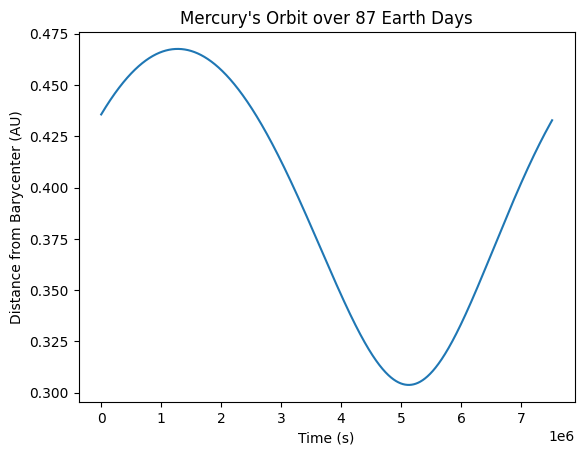

In [135]:
radious_merc = np.sqrt((positions.T[axes[0]][s])**2 + (positions.T[axes[1]][s])**2)

merc_min = np.min(radious_merc)
min_ind = np.where(radious_merc == merc_min)[0][0]


merc_max = np.max(radious_merc)
max_ind = np.where(radious_merc == merc_max)[0][0]

plt.plot(t, radious_merc)

print ("Mercury will reach its {:.3f} AU perihelion {:.3f} days from now".format(merc_min , t[min_ind] /(60*60*24)))
print ("Mercury will reach its {:.3f} AU aphelion {:.3f} days from now".format(merc_max , t[max_ind] /(60*60*24)))
plt.xlabel("Time (s)")
plt.ylabel("Distance from Barycenter (AU)")
plt.title("Mercury's Orbit over 87 Earth Days");


Mercury's actual perihelion and aphelion are .307 AU and .467 AU, respectively.

# Moon Orbit Example

We resolved the solar system for one earth year and inspected the moon's perihelion and aphelion to see if it ever re-crosses its path in the x,y plane. Notice the small jump in the 2nd plot--its origin is unknown. Despite the jump, the plot is not discontinuous.

In [158]:
t0, tf=0, 31536000
t=np.linspace(t0,tf,35000)
qprimeluna_sol=vsolve_rk4(qprimegrav,t,q0)
selectedplanets=[3,4]
axes==[0,1]

positions = np.reshape(qprimeluna_sol, (len(qprimeluna_sol), len(qprimeluna_sol[0])//6, 6))[:,:,(0,1,2)]
positions=positions*6.6846e-12

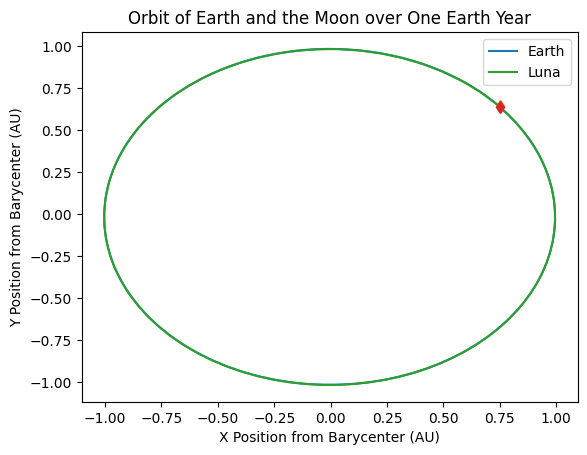

In [159]:
for s in selectedplanets:
  if s ==3 or s==4:
    plt.plot(positions.T[axes[0]][s],positions.T[axes[1]][s],label=names[s])
    plt.plot(positions.T[axes[0]][s][0],positions.T[axes[1]][s][0],'d')
    plt.legend()
  if s==0:
    plt.plot(positions.T[0][0],positions.T[1][0],'y*', label=names[s])

plt.xlabel("X Position from Barycenter (AU)")
plt.ylabel("Y Position from Barycenter (AU)")
plt.title("Orbit of Earth and the Moon over One Earth Year");

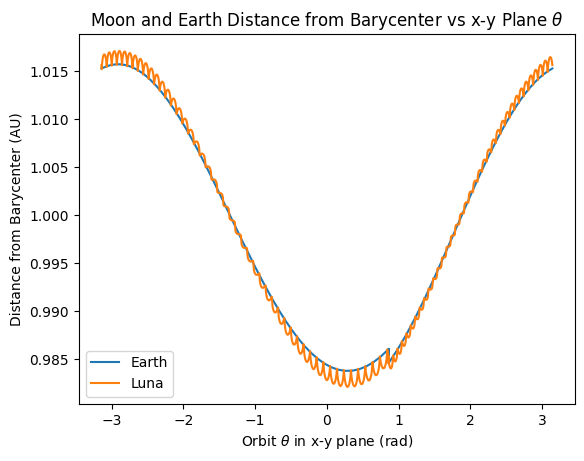

In [160]:
for s in selectedplanets:
  if s == 3 or s==4:
        theta = np.arctan2(positions.T[axes[0]][s], positions.T[axes[1]][s])
        r = np.sqrt(positions.T[axes[0]][s]**2 + positions.T[axes[1]][s]**2)
        sorted_points = sorted(zip(theta, r))
        sorted_theta, sorted_r = zip(*sorted_points)
        plt.plot(sorted_theta, sorted_r, label=names[s])
        plt.legend()

plt.xlabel("Orbit $\\theta$ in x-y plane (rad)")
plt.ylabel("Distance from Barycenter (AU)")
plt.title("Moon and Earth Distance from Barycenter vs x-y Plane $\\theta$");

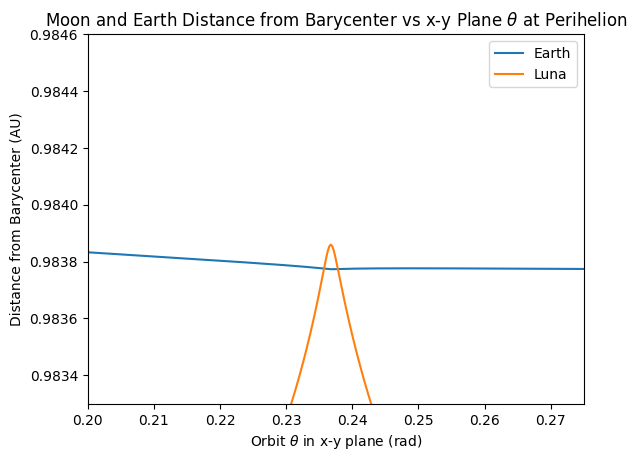

In [161]:
for s in selectedplanets:
  if s == 3 or s==4:
        theta = np.arctan2(positions.T[axes[0]][s], positions.T[axes[1]][s])
        r = np.sqrt(positions.T[axes[0]][s]**2 + positions.T[axes[1]][s]**2)
        sorted_points = sorted(zip(theta, r))
        sorted_theta, sorted_r = zip(*sorted_points)
        plt.plot(sorted_theta, sorted_r, label=names[s])
        plt.legend()
plt.ylim(.98330,.98460)
plt.xlim(.2,.275)
plt.xlabel("Orbit $\\theta$ in x-y plane (rad)")
plt.ylabel("Distance from Barycenter (AU)")
plt.title("Moon and Earth Distance from Barycenter vs x-y Plane $\\theta$ at Perihelion");

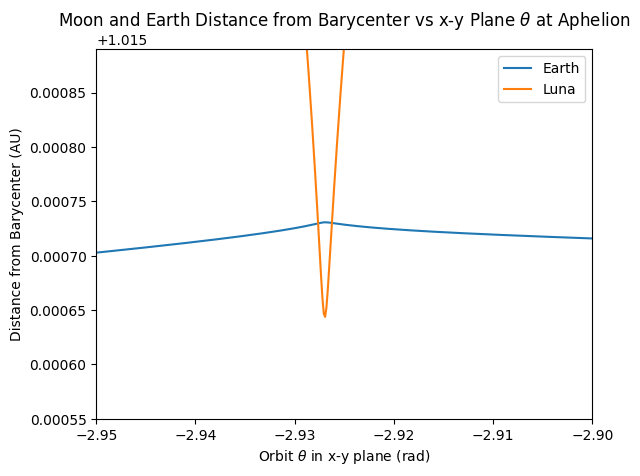

In [162]:
for s in selectedplanets:
  if s == 3 or s==4:
        theta = np.arctan2(positions.T[axes[0]][s], positions.T[axes[1]][s])
        r = np.sqrt(positions.T[axes[0]][s]**2 + positions.T[axes[1]][s]**2)
        sorted_points = sorted(zip(theta, r))
        sorted_theta, sorted_r = zip(*sorted_points)
        plt.plot(sorted_theta, sorted_r, label=names[s])
        plt.legend()
plt.ylim(1.01555,1.01589)
plt.xlim(-2.95,-2.9)
plt.xlabel("Orbit $\\theta$ in x-y plane (rad)")
plt.ylabel("Distance from Barycenter (AU)")
plt.title("Moon and Earth Distance from Barycenter vs x-y Plane $\\theta$ at Aphelion");

Upon close inspection of the perihelion and aphelion, the team determined that the moon never recrossed previous locations during one earth year of orbit. The team analyzed these sections because the orbit of the earth sees the least change in trajectory at those moments. We also observed that the moon's orbital period is approximately the same each time.



# Mars Orbit Example

We proceeded to further solve the solar system for 10 years. Using this solution, we accurately predicted when Mars would be closest to the Earth. This is the only function we wrote that considers data in the z direction.

In [141]:
t0,tf=0,315360000
t=np.linspace(t0,tf,5000)
qprimegrav_sol=vsolve_rk4(qprimegrav,t,q0)

positions = np.reshape(qprimegrav_sol, (len(qprimegrav_sol), len(qprimegrav_sol[0])//6, 6))[:,:,(0,1,2)]
positions=positions*6.6846e-12
selectedplanets=[0, 3,5]
axes=[0,1,2]

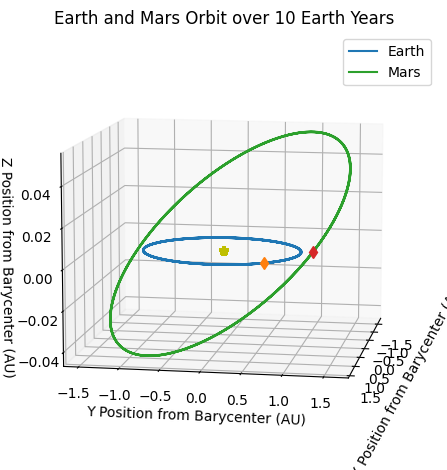

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for s in selectedplanets:
    if s == 3:
        ax.plot(positions.T[axes[0]][s], positions.T[axes[1]][s], positions.T[axes[2]][s], label=names[s])
        ax.plot(positions.T[axes[0]][s][0], positions.T[axes[1]][s][0], positions.T[axes[2]][s][0], 'd')

        xe = positions.T[axes[0]][s]
        ye = positions.T[axes[1]][s]
        ze = positions.T[axes[2]][s]

    if s == 5:
        ax.plot(positions.T[axes[0]][s], positions.T[axes[1]][s], positions.T[axes[2]][s], label=names[s])
        ax.plot(positions.T[axes[0]][s][0], positions.T[axes[1]][s][0], positions.T[axes[2]][s][0], 'd')

        xmars = positions.T[axes[0]][s]
        ymars = positions.T[axes[1]][s]
        zmars = positions.T[axes[2]][s]

    if s == 0:
        ax.plot(positions.T[0][0], positions.T[1][0], positions.T[2][0], 'y*')

ax.legend()
ax.view_init(elev=10, azim=10)
ax.set_xlabel("X Position from Barycenter (AU)")
ax.set_ylabel("Y Position from Barycenter (AU)")
ax.set_zlabel("Z Position from Barycenter (AU)")
ax.set_title("Earth and Mars Orbit over 10 Earth Years")
plt.tight_layout()
plt.show()

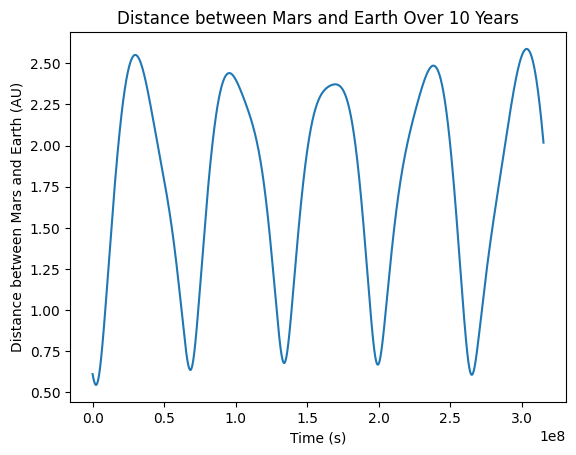

In [143]:
mars_earth=np.sqrt((xmars - xe)**2 + (ymars - ye)**2 + (zmars - ze)**2)

plt.plot(t, mars_earth)
plt.xlabel("Time (s)")
plt.ylabel("Distance between Mars and Earth (AU)")
plt.title("Distance between Mars and Earth Over 10 Years");

In [144]:
from datetime import datetime
me_min = np.min(mars_earth)
indx = np.where(mars_earth == me_min)[0][0]
# "today" is november 3rd, 2022
#now = datetime.datetime(2022, 11, 03)
#day_difference = datetime.timedelta(seconds=(tf-t0)/5000/86400)*(indx+1))
#future = now + day_difference
print("The minimum Mars-Earth distance of %3.3f AU occurs %3.3f days from now on (12, 1, 2022)"%(me_min,t[38]/(60*60*24)))

The minimum Mars-Earth distance of 0.545 AU occurs 27.746 days from now on (12, 1, 2022)


The predicted minimum distance and date of occurence are both accurate [accurate](https://www.nao.ac.jp/en/astro/sky/2016/05-topics03.html).



# Uranus and Neptune Orbit Example

The existence of planet Neptune was inferred from perturbations in Uranus's orbit. In order to display these differences, the team plotted Uranus's orbit with and without Neptune. We solved both systems for approximately 250 years. Upclose plots reveal stark, continuous differences in orbit between the two scenarios.

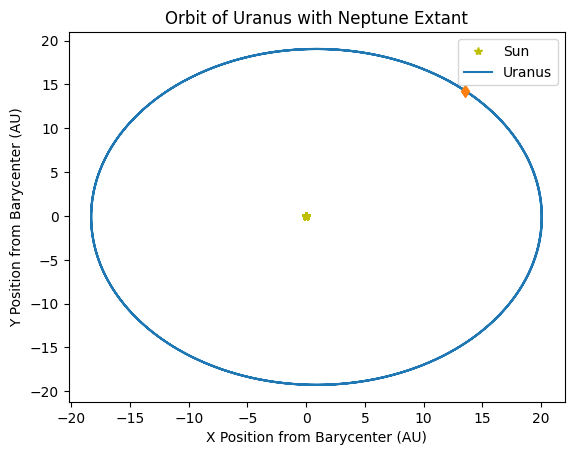

In [145]:
t0,tf=0,8e9
t=np.linspace(t0,tf,5000)

qprimegrav_sol=vsolve_rk4(qprimegrav,t,q0)
positions = np.reshape(qprimegrav_sol, (len(qprimegrav_sol), len(qprimegrav_sol[0])//6, 6))[:,:,(0,1,2)]
positions=positions*6.6846e-12
selectedplanets=[0, 8]
axes=[0,1]
for s in selectedplanets:
  if s != 0:
    plt.plot(positions.T[axes[0]][s],positions.T[axes[1]][s],label=names[s])
    plt.plot(positions.T[axes[0]][s][0],positions.T[axes[1]][s][0],'d')
  if s==0:
    plt.plot(positions.T[0][0],positions.T[1][0],'y*', label = "Sun")
  plt.legend()
plt.xlabel("X Position from Barycenter (AU)")
plt.ylabel("Y Position from Barycenter (AU)")
plt.title("Orbit of Uranus with Neptune Extant")
NEX = positions.T[axes[0]][s]
NEY = positions.T[axes[1]][s]

In [146]:
q = pd.read_csv(
    "https://gist.githubusercontent.com/Theelx/acf32843d9b878ab12fbdfdf6354560e/raw/da92ab5addaac75541066a8c16bf67286061ef98/astro_data.csv"
).to_numpy()
q = q[0:-1]
names = ["Sun", "Mercury", "Venus", "Earth", "Luna", "Mars", "Jupiter", "Saturn", "Uranus"]
q = np.delete(q, 0, 1)
q=np.delete(q,6,1)*1000
q[3][0]=-q[3][0]+1000000
q[3][3]=-q[3][3]
q0=np.reshape(q, (len(q[0])*len(q)))
q2=q
planet_masses = np.array(
    [
        1.989e30,
        3.301e23,
        4.867e24,
        5.972e24,
        7.348e22,
        6.417e23,
        1.898e27,
        5.683e26,
        8.681e25,
    ]
)

In [147]:
t0,tf=0,8e9
t=np.linspace(t0,tf,5000)

qprimegrav_sol=vsolve_rk4(qprimegrav,t,q0)

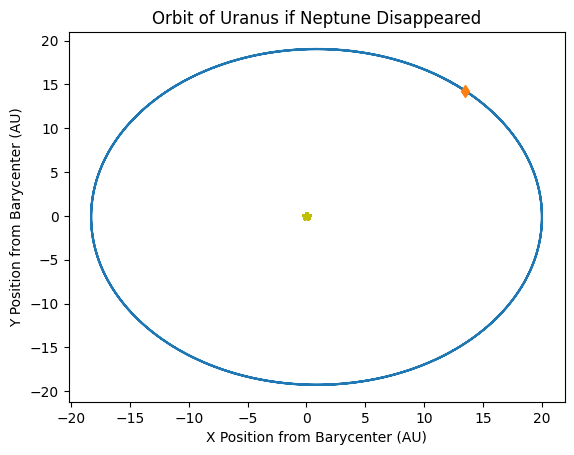

In [148]:
positions = np.reshape(qprimegrav_sol, (len(qprimegrav_sol), len(qprimegrav_sol[0])//6, 6))[:,:,(0,1,2)]
positions=positions*6.6846e-12
selectedplanets=[0, 8]
axes=[0,1]

for s in selectedplanets:
  if s != 0:
    plt.plot(positions.T[axes[0]][s],positions.T[axes[1]][s],label=names[s])
    plt.plot(positions.T[axes[0]][s][0],positions.T[axes[1]][s][0],'d')
  if s==0:
    plt.plot(positions.T[0][0],positions.T[1][0],'y*')
plt.xlabel("X Position from Barycenter (AU)")
plt.ylabel("Y Position from Barycenter (AU)")
plt.title("Orbit of Uranus if Neptune Disappeared");

From above, the orbits seem identical. However, close inspection reveals some nearly imperceptible differences.

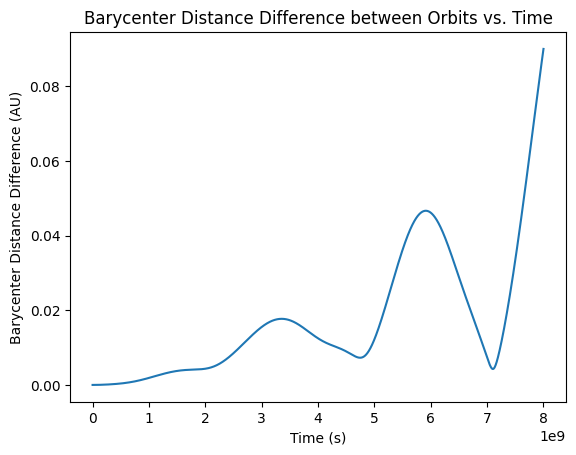

In [149]:
diff=np.sqrt((NEX-positions.T[axes[0]][8])**2 + (NEY-positions.T[axes[1]][8])**2)

plt.plot(t, diff)
plt.xlabel("Time (s)")
plt.ylabel("Barycenter Distance Difference (AU)")
plt.title("Barycenter Distance Difference between Orbits vs. Time");

The orbits appear to diverge in time by some form of $xsin(x)$.

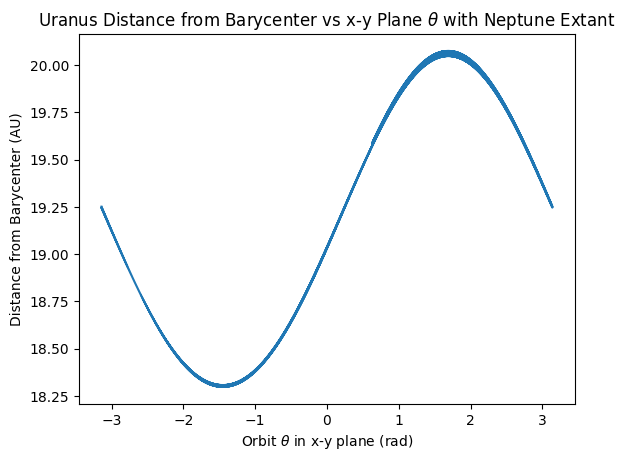

In [150]:
theta1 = np.arctan2(NEX, NEY)
r1 = np.sqrt(NEX**2 + NEY**2)
sorted_points = sorted(zip(theta1, r1))
sorted_theta1, sorted_r1 = zip(*sorted_points)
plt.plot(sorted_theta1, sorted_r1, label=names[s])
plt.xlabel("Orbit $\\theta$ in x-y plane (rad)")
plt.ylabel("Distance from Barycenter (AU)")
plt.title("Uranus Distance from Barycenter vs x-y Plane $\\theta$ with Neptune Extant");

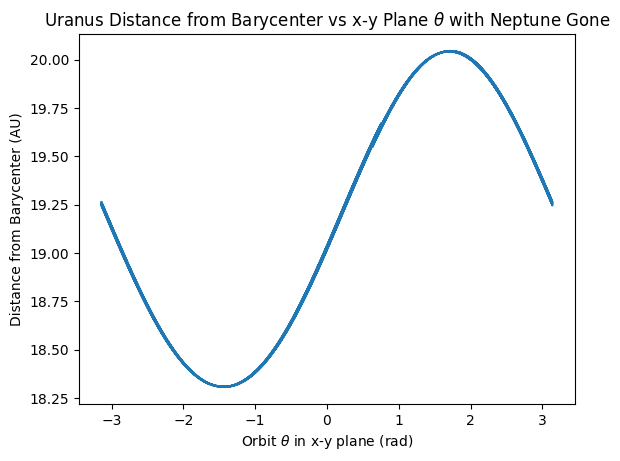

In [151]:
theta2 = np.arctan2(positions.T[axes[0]][8], positions.T[axes[1]][8])
r2 = np.sqrt(positions.T[axes[0]][8]**2 + positions.T[axes[1]][8]**2)
sorted_points = sorted(zip(theta2, r2))
sorted_theta2, sorted_r2 = zip(*sorted_points)
plt.plot(sorted_theta2, sorted_r2, label=names[s])
plt.xlabel("Orbit $\\theta$ in x-y plane (rad)")
plt.ylabel("Distance from Barycenter (AU)")
plt.title("Uranus Distance from Barycenter vs x-y Plane $\\theta$ with Neptune Gone");

With Neptune absent, Uranus's nutation rate seems to shift--growing in some parts and shrinking in others.

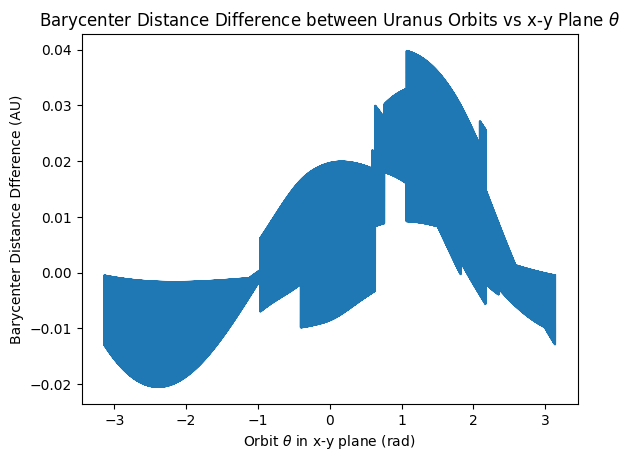

In [152]:
import operator
plt.plot(sorted_theta1, tuple(map(lambda i, j: i - j, sorted_r1, sorted_r2)), label=names[s])
plt.xlabel("Orbit $\\theta$ in x-y plane (rad)")
plt.ylabel("Barycenter Distance Dfference (AU)")
plt.title("Barycenter Distance Difference between Uranus Orbits vs x-y Plane $\\theta$");

It seems that, if Neptune's orbit was removed, Uranus's nutation rate would increase for the first half of its orbit and decrease for the second half.

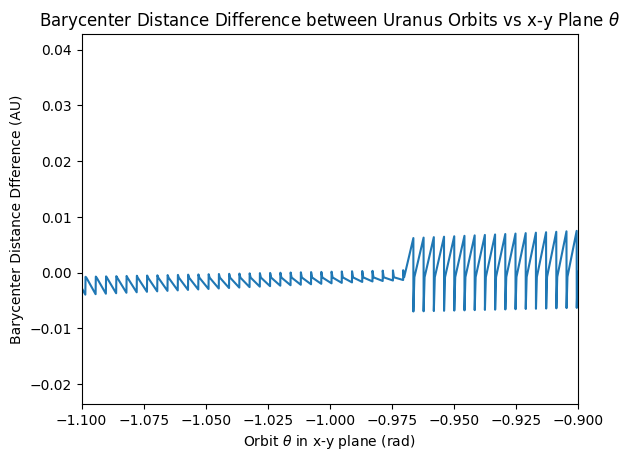

In [153]:
plt.plot(sorted_theta1, tuple(map(lambda i, j: i - j, sorted_r1, sorted_r2)), label=names[s])
plt.xlim(-1.1,-.9);
plt.xlabel("Orbit $\\theta$ in x-y plane (rad)")
plt.ylabel("Barycenter Distance Dfference (AU)")
plt.title("Barycenter Distance Difference between Uranus Orbits vs x-y Plane $\\theta$");

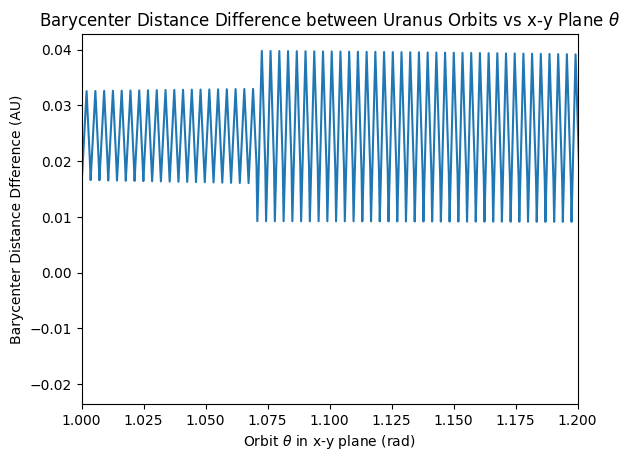

In [154]:
plt.plot(sorted_theta1, tuple(map(lambda i, j: i - j, sorted_r1, sorted_r2)), label=names[s])
plt.xlim(1,1.2);
plt.xlabel("Orbit $\\theta$ in x-y plane (rad)")
plt.ylabel("Barycenter Distance Dfference (AU)")
plt.title("Barycenter Distance Difference between Uranus Orbits vs x-y Plane $\\theta$");

Plots to show continuity

# For Fun: Solar System in 3D

In [155]:
q = pd.read_csv(
    "https://gist.githubusercontent.com/Theelx/acf32843d9b878ab12fbdfdf6354560e/raw/da92ab5addaac75541066a8c16bf67286061ef98/astro_data.csv"
).to_numpy()
names = ["Sun", "Mercury", "Venus", "Earth", "Luna", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"]
#1 m/s = 5.77548e-7 au/day
#1 m = 6.6846e-12 au       m/au  = 6.6846e-12

#1 s = 1.1574e-5 days      s/day = 1.1574e-5
#1/s = 8.64e4 1/days
#G = 6.6738e-11 m^3/(kg*s^2)  =>  multiply by (au/m)^3, (s/day)^2  => G=
q = np.delete(q, 0, 1)
q=np.delete(q,6,1)*1000
q[3][0]=-q[3][0]
q[3][3]=-q[3][3]
q0=np.reshape(q, (len(q[0])*len(q)))
q2=q
planet_masses = np.array(
    [
        1.989e30,
        3.301e23,
        4.867e24,
        5.972e24,
        7.348e22,
        6.417e23,
        1.898e27,
        5.683e26,
        8.681e25,
        1.024e26,
    ]
)

In [156]:
t0,tf=0,31536000
t=np.linspace(t0,tf,30000)
qprimegrav_sol=vsolve_rk4(qprimegrav,t,q0)
positions = np.reshape(qprimegrav_sol, (len(qprimegrav_sol), len(qprimegrav_sol[0])//6, 6))[:,:,(0,1,2)]
selectedplanets=[0,1,2,3,5, 6,7,8,9]
positions=positions*6.6846e-12

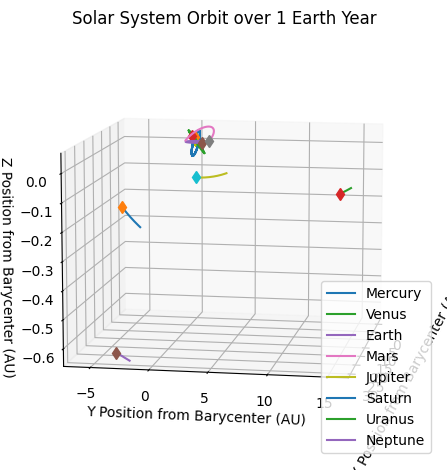

In [157]:
axes=[0,1,2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for s in selectedplanets:
  if s != 0:
        ax.plot(positions.T[axes[0]][s], positions.T[axes[1]][s], positions.T[axes[2]][s], label=names[s])
        ax.plot(positions.T[axes[0]][s][0], positions.T[axes[1]][s][0], positions.T[axes[2]][s][0], 'd')
  if s==0:
        ax.plot(positions.T[0][0], positions.T[1][0], positions.T[2][0], 'y*')

ax.legend()
ax.set_xlabel("X Position from Barycenter (AU)")
ax.set_ylabel("Y Position from Barycenter (AU)")
ax.set_zlabel("Z Position from Barycenter (AU)")
ax.set_title("Solar System Orbit over 1 Earth Year")
ax.view_init(elev=10, azim=10)
plt.tight_layout()
plt.show()